# Réseaux de neurones à convolution


Exemple de réseau de neurones à convolution (CNN) sur les données FashionMNIST, avec pytorch
 

[REQUIREMENTS.txt](#requirements)

In [17]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# --- Torchvision : charger les données

train_dataset = torchvision.datasets.FashionMNIST(
    root='../tmp',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

test_dataset = torchvision.datasets.FashionMNIST(
    root='../tmp',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)


0.4%

100.0%


Extracting ../tmp\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../tmp\FashionMNIST\raw


100.0%


Extracting ../tmp\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../tmp\FashionMNIST\raw




13.3%

100.0%


Extracting ../tmp\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../tmp\FashionMNIST\raw



100.0%

Extracting ../tmp\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../tmp\FashionMNIST\raw



In [3]:
print('Shape du jeu d''entrainement:', train_dataset.data.shape)
print('Target du jeu d''entrainement: ', train_dataset.targets)

Shape du jeu dentrainement: torch.Size([60000, 28, 28])
Target du jeu dentrainement:  tensor([9, 0, 0,  ..., 3, 0, 5])


In [4]:
print('Shape du jeu de test:', test_dataset.data.shape)
print('Target du jeu de test: ', test_dataset.targets)

Shape du jeu de test: torch.Size([10000, 28, 28])
Target du jeu de test:  tensor([9, 2, 1,  ..., 8, 1, 5])


In [5]:
# --- Nombre de classes de la target
K = len(torch.unique(train_dataset.targets).numpy())
K

10

In [6]:
class CNN(nn.Module):
    
    def __init__(self, K):
        '''
        Constructor for our custom cnn model
        '''
        super(CNN,self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
            nn.ReLU()
        )
    
        self.dense_layers = nn.Sequential(
                nn.Dropout(0.2),
                nn.Linear(128 * 2 * 2, 512),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(512, K)
            )
    
    def forward(self, X):
        '''
        Forward pass
        '''
        out = self.conv_layers(X)
        out = out.view(out.size(0), -1)
        out = self.dense_layers(out)

        return out


model = CNN(K)

In [7]:
# --- GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

model.to(device)

cuda:0


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [8]:
# --- Entraîner le modèle

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

batch_size = 128
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True
)

test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    shuffle = False
)

def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        model.train()
        t0 = datetime.now()
        train_loss = []

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
        
        train_loss = np.mean(train_loss)

        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        
        test_loss = np.mean(test_loss)

        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0
        print(f'''Epoch {it+1}/{epochs}\n-----------------
        Train Loss: {train_loss:.4f}
        Test Loss: {test_loss:.4f}
        Duration: {dt}
        ''')
    return train_losses, test_losses

In [9]:
# lancer la boucle d'entraînement
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=15)

Epoch 1/15
-----------------
        Train Loss: 0.6493
        Test Loss: 0.4825
        Duration: 0:00:13.235046
        
Epoch 2/15
-----------------
        Train Loss: 0.4338
        Test Loss: 0.4023
        Duration: 0:00:11.486540
        
Epoch 3/15
-----------------
        Train Loss: 0.3763
        Test Loss: 0.3747
        Duration: 0:00:11.199593
        
Epoch 4/15
-----------------
        Train Loss: 0.3377
        Test Loss: 0.3395
        Duration: 0:00:11.232781
        
Epoch 5/15
-----------------
        Train Loss: 0.3114
        Test Loss: 0.3150
        Duration: 0:00:13.731919
        
Epoch 6/15
-----------------
        Train Loss: 0.2880
        Test Loss: 0.3066
        Duration: 0:00:13.960730
        
Epoch 7/15
-----------------
        Train Loss: 0.2691
        Test Loss: 0.3023
        Duration: 0:00:13.919672
        
Epoch 8/15
-----------------
        Train Loss: 0.2539
        Test Loss: 0.2861
        Duration: 0:00:13.974400
        
Epoch 9/

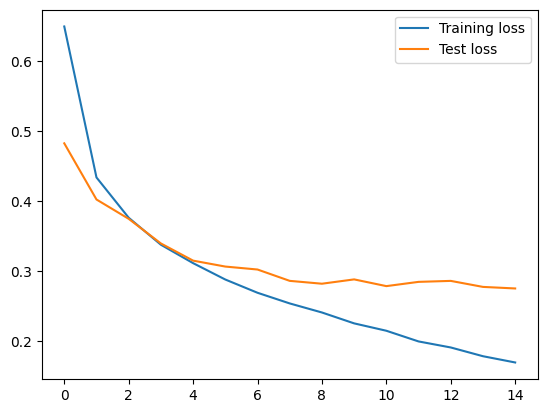

In [10]:
# Loss par itération
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.legend()
plt.show()

In [11]:
# Accuracy

model.eval()

# train
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_accuracy = n_correct/n_total

# test
n_correct = 0.
n_total = 0.
pred_test = np.array([])
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]
    pred_test = np.concatenate((pred_test, predictions.cpu().numpy()))

test_accuracy = n_correct/n_total

print(f'Train accuracy: {train_accuracy:.4f}, Test accuracy: {test_accuracy:.4f}')

Train accuracy: 0.9564, Test accuracy: 0.9034


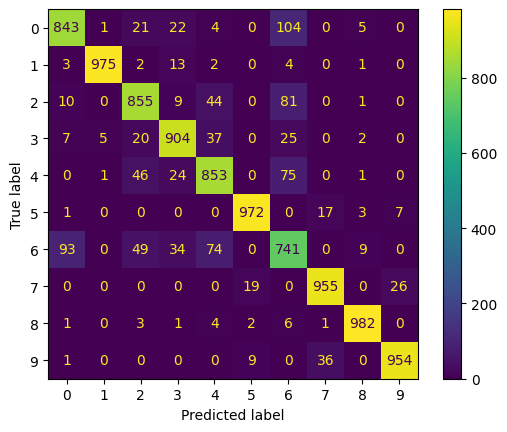

In [12]:
# --- Matrice de confusion

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()

cm = confusion_matrix(y_test, pred_test)

cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=torch.unique(test_dataset.targets).numpy()
)

cm_display.plot()
plt.show()

In [13]:
true_labels = 'T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot'.split(',')


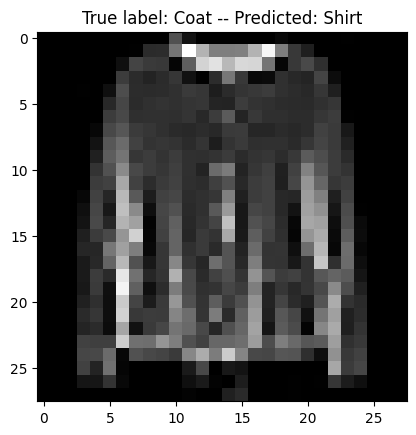

In [16]:
# --- Visualiser quelques cas de mauvaise prédiction

missclassified_idx = np.where(pred_test != y_test)[0]
i = np.random.choice(missclassified_idx)
plt.imshow(x_test[i], cmap='gray')
plt.title(f'True label: {true_labels[y_test[i]]} -- Predicted: {true_labels[int(pred_test[i])]}')
plt.show()

## <a id="requirements" style="color:black">REQUIREMENTS.txt</a>

<span style="color:orange">Ce notebook a été créé avec python 3.10</span>

Requirements.txt  

```
alembic==1.13.2
aniso8601==9.0.1
anyio==4.4.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==2.4.1
async-lru==2.0.4
attrs==23.2.0
Babel==2.15.0
bcrypt==4.1.3
beautifulsoup4==4.12.3      
bleach==6.1.0
blinker==1.8.2
boto3==1.35.35
botocore==1.35.40
cachetools==5.4.0
certifi==2024.6.2
cffi==1.16.0
charset-normalizer==3.3.2   
click==8.1.7
cloudpickle==3.0.0
colorama==0.4.6
comm==0.2.2
contourpy==1.2.1
cryptography==42.0.8        
cycler==0.12.1
databricks-sdk==0.31.1      
debugpy==1.8.1
decorator==5.1.1
defusedxml==0.7.1
Deprecated==1.2.14
docker==7.1.0
entrypoints==0.4
exceptiongroup==1.2.1
executing==2.0.1
fastjsonschema==2.19.1
filelock==3.13.1
Flask==3.0.3
fonttools==4.53.0
fqdn==1.5.1
fsspec==2024.2.0
gitdb==4.0.11
GitPython==3.1.43
google-auth==2.34.0
graphene==3.3
graphql-core==3.2.3
graphql-relay==3.2.0
greenlet==3.0.3
h11==0.14.0
httpcore==1.0.5
httpx==0.27.0
idna==3.7
imageio==2.35.1
importlib_metadata==7.1.0
intel-openmp==2021.4.0
ipykernel==6.29.4
ipython==8.25.0
ipywidgets==8.1.3
isoduration==20.11.0
itsdangerous==2.2.0
jedi==0.19.1
Jinja2==3.1.3
jmespath==1.0.1
joblib==1.4.2
json5==0.9.25
jsonpointer==3.0.0
jsonschema==4.22.0
jsonschema-specifications==2023.12.1
jupyter==1.0.0
jupyter-console==6.6.3
jupyter-events==0.10.0
jupyter-lsp==2.2.5
jupyter_client==8.6.2
jupyter_core==5.7.2
jupyter_server==2.14.1
jupyter_server_terminals==0.5.3
jupyterlab==4.2.2
jupyterlab_pygments==0.3.0
jupyterlab_server==2.27.2
jupyterlab_widgets==3.0.11
kiwisolver==1.4.5
lazy_loader==0.4
Mako==1.3.5
Markdown==3.6
MarkupSafe==2.1.5
matplotlib==3.9.0
matplotlib-inline==0.1.7
mistune==3.0.2
mkl==2021.4.0
mlflow==2.15.1
mlflow-skinny==2.15.1
mpmath==1.3.0
nbclient==0.10.0
nbconvert==7.16.4
nbformat==5.10.4
nest-asyncio==1.6.0
networkx==3.2.1
notebook==7.2.1
notebook_shim==0.2.4
numpy==1.26.3
opentelemetry-api==1.25.0
opentelemetry-sdk==1.25.0
opentelemetry-semantic-conventions==0.46b0
overrides==7.7.0
packaging==24.1
pandas==2.2.2
pandocfilters==1.5.1
paramiko==3.4.0
parso==0.8.4
pillow==10.2.0
platformdirs==4.2.2
prometheus_client==0.20.0
prompt_toolkit==3.0.47
protobuf==5.28.2
psutil==5.9.8
pure-eval==0.2.2
pyarrow==15.0.2
pyasn1==0.6.0
pyasn1_modules==0.4.0
pycparser==2.22
Pygments==2.18.0
PyNaCl==1.5.0
pyparsing==3.1.2
pysftp==0.2.8
python-dateutil==2.9.0.post0
python-json-logger==2.0.7
pytz==2024.1
pywin32==306
pywinpty==2.0.13
PyYAML==6.0.1
pyzmq==26.0.3
qtconsole==5.5.2
QtPy==2.4.1
querystring-parser==1.2.4
referencing==0.35.1
requests==2.32.3
rfc3339-validator==0.1.4
rfc3986-validator==0.1.1
rpds-py==0.18.1
rsa==4.9
s3transfer==0.10.3
scikit-image==0.24.0
scikit-learn==1.5.1
scipy==1.14.0
Send2Trash==1.8.3
six==1.16.0
smmap==5.0.1
sniffio==1.3.1
soupsieve==2.5
SQLAlchemy==2.0.31
sqlparse==0.5.1
stack-data==0.6.3
sympy==1.12
tbb==2021.11.0
terminado==0.18.1
threadpoolctl==3.5.0
tifffile==2024.9.20
tinycss2==1.3.0
tomli==2.0.1
torch==2.3.1+cu121
torchaudio==2.3.1+cu121
torchvision==0.18.1+cu121
tornado==6.4.1
traitlets==5.14.3
types-python-dateutil==2.9.0.20240316
typing_extensions==4.9.0
tzdata==2024.1
uri-template==1.3.0
urllib3==2.2.1
waitress==3.0.0
wcwidth==0.2.13
webcolors==24.6.0
webencodings==0.5.1
websocket-client==1.8.0
Werkzeug==3.0.3
widgetsnbextension==4.0.11
wrapt==1.16.0
zipp==3.19.2
```